<a href="https://colab.research.google.com/github/Paul-mwaura/Natural-Language-Processing/blob/main/Gender_Based_Discrimination_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re
import nltk
import string
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

stop = stopwords.words('english')
nltk.download('stopwords')
nltk.download("punkt")
nltk.download("wordnet")

from wordcloud import WordCloud,STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import linear_model
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading the Dataset

In [79]:
df = pd.read_csv('clean_tweets.csv')
df.head()

,Unnamed: 0,date,time,username,tweet,replies_count,retweets_count,likes_count
0,0,2021-04-20,23:59:58,bigboy00715,I heard a call to violence,0,1,1
1,1,2021-04-20,23:59:58,mrcartoonster,@whitefish_ARCH @abby4thepeople YES!!! The Lef...,0,0,4
2,2,2021-04-20,23:59:55,canadian_mom73,A 15 year old girl shot and killed by the poli...,1,0,1
3,3,2021-04-20,23:59:54,coconservative7,@GovtsTheProblem Did we really think in a coun...,0,0,0
4,4,2021-04-20,23:59:53,faisalrahman36,@rehamnm1 @ImranKhanPTI Even if you hate @Imra...,0,0,0


In [80]:
df.columns

Index(['Unnamed: 0', 'date', 'time', 'username', 'tweet', 'replies_count',
       'retweets_count', 'likes_count'],
      dtype='object')

In [81]:
df = df.iloc[:, 1:]
df.head(2)

,date,time,username,tweet,replies_count,retweets_count,likes_count
0,2021-04-20,23:59:58,bigboy00715,I heard a call to violence,0,1,1
1,2021-04-20,23:59:58,mrcartoonster,@whitefish_ARCH @abby4thepeople YES!!! The Lef...,0,0,4


In [82]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
replies_count,3366.0,1.071004,8.141031,0.0,0.0,0.0,1.0,219.0
retweets_count,3366.0,2.614082,34.777056,0.0,0.0,0.0,0.0,1040.0
likes_count,3366.0,14.957813,185.242502,0.0,0.0,1.0,3.0,6314.0


### Data Cleaning

In [83]:
df.isna().sum()

date              0
time              0
username          0
tweet             0
replies_count     0
retweets_count    0
likes_count       0
dtype: int64

In [84]:
df.duplicated().sum()

0

### Text Preprocessing

In [85]:
tweet = df['tweet']
tweet.iloc[:3]

0                           I heard a call to violence
1    @whitefish_ARCH @abby4thepeople YES!!! The Lef...
2    A 15 year old girl shot and killed by the poli...
Name: tweet, dtype: object

In [86]:
tweets = []
for word in tweet:
  word = re.sub('@[\w]+','',word)
  tweets.append(word)

In [87]:
tweets[:3]

['I heard a call to violence',
 '  YES!!! The Left Hand of Darkness is fun and introduced me to the concept that sex and gender are not the same things, which is not taught in the US, on purpose;).',
 'A 15 year old girl shot and killed by the police. When is this police violence  going to end???']

In [88]:
df.columns

Index(['date', 'time', 'username', 'tweet', 'replies_count', 'retweets_count',
       'likes_count'],
      dtype='object')

In [89]:
df['new_tweets'] = tweets
# rearrange the order of the columns.
df = df[['date', 'time', 'username', 'tweet', 'new_tweets', 'replies_count', 'retweets_count','likes_count']]
df.head()

,date,time,username,tweet,new_tweets,replies_count,retweets_count,likes_count
0,2021-04-20,23:59:58,bigboy00715,I heard a call to violence,I heard a call to violence,0,1,1
1,2021-04-20,23:59:58,mrcartoonster,@whitefish_ARCH @abby4thepeople YES!!! The Lef...,YES!!! The Left Hand of Darkness is fun and ...,0,0,4
2,2021-04-20,23:59:55,canadian_mom73,A 15 year old girl shot and killed by the poli...,A 15 year old girl shot and killed by the poli...,1,0,1
3,2021-04-20,23:59:54,coconservative7,@GovtsTheProblem Did we really think in a coun...,Did we really think in a country without the ...,0,0,0
4,2021-04-20,23:59:53,faisalrahman36,@rehamnm1 @ImranKhanPTI Even if you hate @Imra...,Even if you hate or which your right but i...,0,0,0


In [90]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def cleaning(text, stem_words=True):    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

    stops = set(stopwords.words("english"))
    # Clean the text, with the option to stem words.
    
    # Empty question
    
    if type(text) != str or text=='':
        return ''

    # Clean the text
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub("[%s]" % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub("\w*\d\w*", "", text)


    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    ## all numbers should separate from words, this is too aggressive
    
    def pad_number(pattern):
        matched_string = pattern.group(0)
        return pad_str(matched_string)
    text = re.sub('[0-9]+', pad_number, text)
    
    # add padding to punctuations and special chars, we still need them later
    
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
    def pad_pattern(pattern):
       matched_string = pattern.group(0)
       return pad_str(matched_string)
    text = re.sub('[\!\?\@\^\+\*\/\,\~\|\`\=\:\;\.\#\\\]', pad_pattern, text) 
        
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) # replace non-ascii word with special word
    
    # kenyan shillings
    
    text = re.sub("(?<=[0-9])ks ", " ks ", text, flags=re.IGNORECASE)
    text = re.sub(" ks(?=[0-9])", " ks ", text, flags=re.IGNORECASE)
    
    text = [c for c in text if c not in string.punctuation]
    text = [c for c in text if c != '\n'] # Removing newline
    text = ''.join(text)
    text = text.split('https')[0] # Remove links
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
    
    text = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(text))
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()
       # Return a list of words
    return text

In [92]:
# Clean the tweets.
df['clean_tweets'] = df['new_tweets'].apply(cleaning)

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df['tweets_without_stopwords'] = df['clean_tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df = df[['date', 'time', 'username', 'tweet', 'new_tweets', 'clean_tweets', 'tweets_without_stopwords', 'replies_count', 'retweets_count','likes_count']]
df.head(3)

,date,time,username,tweet,new_tweets,clean_tweets,tweets_without_stopwords,replies_count,retweets_count,likes_count
0,2021-04-20,23:59:58,bigboy00715,I heard a call to violence,I heard a call to violence,i heard a call to violence,heard call violence,0,1,1
1,2021-04-20,23:59:58,mrcartoonster,@whitefish_ARCH @abby4thepeople YES!!! The Lef...,YES!!! The Left Hand of Darkness is fun and ...,yes the left hand of darkness is fun and int...,yes left hand darkness fun introduced concept ...,0,0,4
2,2021-04-20,23:59:55,canadian_mom73,A 15 year old girl shot and killed by the poli...,A 15 year old girl shot and killed by the poli...,a year old girl shot and killed by the police...,year old girl shot killed police police violen...,1,0,1


### Exploratory Data Analysis

In [93]:
tweets_df = pd.DataFrame()
tweets_df['clean_tweets'] = df['tweets_without_stopwords']
tweets_df.head(2)

,clean_tweets
0,heard call violence
1,yes left hand darkness fun introduced concept ...


#### Word Cloud

In [96]:
# Create a word cloud
#
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (12, 8))
    plt.imshow(wordcloud)
    plt.axis("off")
    
    plt.show()

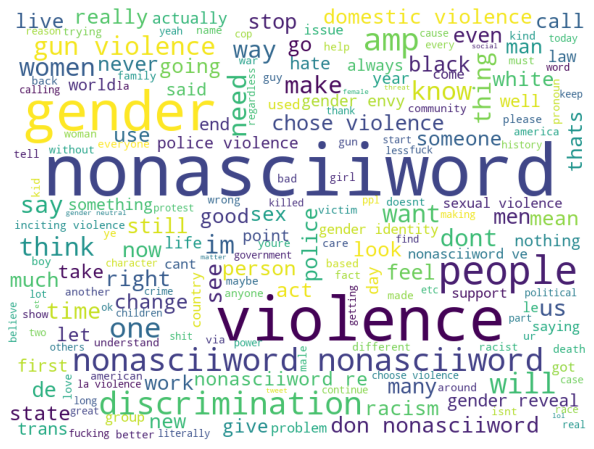

In [97]:
# display the word cloud.
#
cloud(' '.join(df['clean_tweets']))

In [103]:
# Get Word Value Counts.
from collections import Counter
tweets_df['text_list'] = tweets_df['clean_tweets'].apply(lambda x:str(x).split())
top = Counter([item for sublist in tweets_df['text_list'] for item in sublist]) # Counts the frequency of words.
temp = pd.DataFrame(top.most_common(20)) # DataFrame of top 20
temp.columns = ["common_words", "count"]
temp.style.background_gradient(cmap="Blues")

,common_words,count
0,nonasciiword,2367
1,violence,1825
2,gender,1329
3,people,417
4,like,297
5,amp,263
6,discrimination,256
7,police,198
8,gun,187
9,women,171


### Finding a Solution

#### Sentiment Analysis

#### TFIDF

In [106]:
# TFIDF Vectorizer.
corpus = tweets_df['clean_tweets']
vectorizer = TfidfVectorizer(stop_words='english', analyzer='word')
X = vectorizer.fit_transform(corpus)
idf = vectorizer.idf_
vectorizer.vocabulary_

{'heard': 4553,
 'violence': 10875,
 'yes': 11289,
 'left': 5777,
 'hand': 4454,
 'darkness': 2431,
 'fun': 4010,
 'introduced': 5232,
 'concept': 2007,
 'sex': 9058,
 'gender': 4093,
 'things': 10139,
 'taught': 9983,
 'purpose': 8040,
 'year': 11283,
 'old': 7036,
 'girl': 4200,
 'shot': 9154,
 'killed': 5579,
 'police': 7636,
 'going': 4251,
 'end': 3247,
 'really': 8248,
 'think': 10142,
 'country': 2229,
 'courage': 2239,
 'church': 1745,
 'work': 11200,
 'school': 8880,
 'face': 3588,
 'survival': 9856,
 'rate': 8207,
 'virus': 10899,
 'jury': 5472,
 'convict': 2164,
 'identities': 4852,
 'revealed': 8565,
 'politicians': 7654,
 'threatened': 10167,
 'derekchauvintrial': 2648,
 'hate': 4514,
 'right': 8613,
 'mixing': 6471,
 'protests': 7951,
 'common': 1945,
 'person': 7464,
 'attacked': 722,
 'pti': 7998,
 'amp': 415,
 'tlps': 10247,
 'people': 7408,
 'property': 7919,
 'looks': 5982,
 'disappointing': 2791,
 'congratulations': 2062,
 'libby': 5853,
 'wgea': 11085,
 'staffs': 9

### Building a Classifier